# Computer Exercise 2
## Transfer function models and prediction

Time Series Analysis  
Lund University, Fall 2025

In this computer exercise, we will work with input-output relations, as well as prediction in time series models. Firstly, you will be acquainted with time series having an exogenous input, having to analyze the impulse response of such a system and from it build a suitable model. Secondly, we will examine how one can predict a time series, perhaps the most important application of time series modeling. You will be expected to make predictions of all models introduced in this course.

## Preparations before the lab

Review chapters 3, 4, and carefully read chapter 6 in the course textbook. Make sure to read section 4.5 in particular, as it deals with transfer function models, as well as this entire computer exercise guide.

Answers to some of the computer exercise will be graded using the course's *Mozquizto* page. Ensure that you can access the system before the exercise and answer the preparatory questions as well as (at least) three of numbered exercise questions below *before the exercise*.

You can find the *Mozquizto* system at <https://quizms.maths.lth.se>

It should be stressed that a thorough understanding of the material in this exercise is important to be able to complete the course project, and we encourage you to discuss any questions you might have on the exercises with the teaching staff. This will save you a lot of time when you start working with the project!

You are allowed to solve the exercise in groups of two, but not more. Please respect this.

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os
import importlib
import scipy.io

from tsa_lth.analysis import plotACFnPACF, normplot, xcorr, pzmap, kovarians
from tsa_lth.modelling import estimateARMA, polydiv, estimateBJ, PEM
from tsa_lth.tests import whiteness_test, check_if_normal
from scipy.stats import norm

# Set data directory
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')

## Lab Tasks

### 2.1 Modeling of an exogenous input signal

In this and in the next section, you will work with modeling of input-output relations, both using the ARMAX model and the transfer function model framework. As modeling of a signal which has an exogenous input (an input which is known, i.e., deterministic) is generally more complex than the common time series models encountered so far in this course, one must take care and proceed with caution. Often very simple models of a low order will suffice, while complex ones will only add variance, detrimental to the precision of predictions.

We start by creating a typical time series with a deterministic input signal, using a slight generalization of the ARMAX model, i.e., the Box-Jenkins (BJ) model, having the form of

$$
y_t = \frac{B(z) z^{-d}}{A_2(z)} x_{t} + \frac{C_1(z)}{A_1(z)} e_t 
$$

where $y_t$ is the output signal, $e_t$ is a white noise, $x_t$ is the input signal, and $d$ is the time delay between input and output. Note that if $A_1(z) = A_2(z)$, we have the standard ARMAX model.

Begin by generating some data following the Box-Jenkins model:

**PART 1 — Generate the data**
- 1.	Create input signal x_t from ARMA(1,2).
- 2.	Create output signal y_t using the Box-Jenkins model.
- 3.	Remove first 100 samples (to avoid initialization issues).

In [3]:
rng = np.random.default_rng(0)
n = 500 #number of samples

# Generate input signal
A3 = np.array([1.0, 0.5])
C3 = np.array([1.0, -0.3, 0.2])
w = np.sqrt(2.0) * rng.standard_normal(n + 100)
x = signal.lfilter(C3, A3, w)

# Generate output signal
A1 = np.array([1.0, -0.65])
A2 = np.array([1.0, 0.90, 0.78])
B = np.array([0.0, 0.0, 0.0, 0.0, 0.4])
C = np.array([1.0])
e = np.sqrt(1.5) * rng.standard_normal(n + 100)
y = signal.lfilter(C, A1, e) + signal.lfilter(B, A2, x)

# Remove samples
x = x[100:]
y = y[100:]

# Clear the true parameters
del A1, A2, B, C, e, w, A3, C3

Here, the known input $x_t$ has been generated as an ARMA(1,2) process.

**Remark:** As discussed in the first computer exercise, we typically generate more data than needed when simulating a process to avoid initialisation effects. We here also clear the variables used to create the signals to avoid the risk of accidentally referring to these later in the code. One notable benefit of using simulated data in this way is that we know the true values we seek, so we can compare our results with these to see if our code works properly.

In order to now model $y_t$ as a time series formed from $x_t$ and $e_t$, several steps must be taken beyond regular ARMA modeling. We must first select the appropriate model orders for the polynomials in the model, then proceeding to estimate the parameters of these polynomials. This may be done in various ways; here, we will follow the steps outlined in Section 4.5 in the course textbook. However, it should be noted that if you can select your model orders in another way, including simply guessing, this is fully acceptable - what counts is if your model actually works, not the intermediate steps used to designed it!

#### Step 1: Determine orders of B(z) and A₂(z)

As a first step, we wish to determine the orders of the $B(z)$ and $A_2(z)$ polynomials. Using the transfer function framework, we denote the transfer function from $x_t$ to $y_t$ by $H(z) = B(z)z^{-d} / A_2(z)$. In order to estimate the order of the $B(z)$ and $A_2(z)$ polynomials, as well as determining the delay $d$, we need to form an estimate of the (possibly infinite) impulse response, and from it identify the appropriate models for these polynomials.

As noted in the course textbook, if $x_t$ is a white noise, the (scaled) impulse response can be directly estimated using the cross correlation function (CCF) from $x_t$ to $y_t$. However, if $x_t$ is not white, we need to perform pre-whitening, i.e., we need to form a model for the input, such that it may be viewed as being driven by a white noise, and then inverse filter both input and output with this model. In order to do so, we form an ARMA model of the input

$$
A_3(z) x_t = C_3(z) w_t
$$

and then replace $x_t$ with $w_t$, i.e.,

$$
y_t =  \frac{B(z)z^{-d}}{A_2(z)} \frac{C_3(z)}{A_3(z)} w_t + \frac{C_1(z)}{A_1(z)} e_t 
$$

The pre-whitening step, i.e., multiplying with $A_3(z) / C_3(z)$, yields

$$
\underbrace{\frac{A_3(z)}{C_3(z)} y_t}_{\epsilon_t} =  \underbrace{\frac{B(z)z^{-d}}{A_2(z)}}_{H(z)}  w_t +  \underbrace{\frac{A_3(z)}{C_3(z)} \frac{C_1(z)}{A_1(z)} e_t}_{v_t} 
$$

and the preferred transfer function model may thus be expressed as

$$
\epsilon_t=   H(z) w_t + v_t 
$$

Note that the pre-whitened $\epsilon_t$ is now the output of the transfer function model, having the preferred uncorrelated signal as its input, allowing $H(z)$ to be estimated using the CCF from $w_t$ to $\epsilon_t$.

**Task:** Use the basic analysis (acf, pacf, and normplot) to create an ARMA model for the input signal $x_t$ as a function of a white noise, $w_t$. Which model did you find most suitable for $x_t$? Is it reasonably close to the one you used to generate the input?

**QUESTION 1:** In Mozquizto, answer question 1.

-	Use ACF/PACF and normal plots to identify an ARMA model for xₜ.
-	Fit the model and extract the innovations wₜ (the “whitened” version of x).

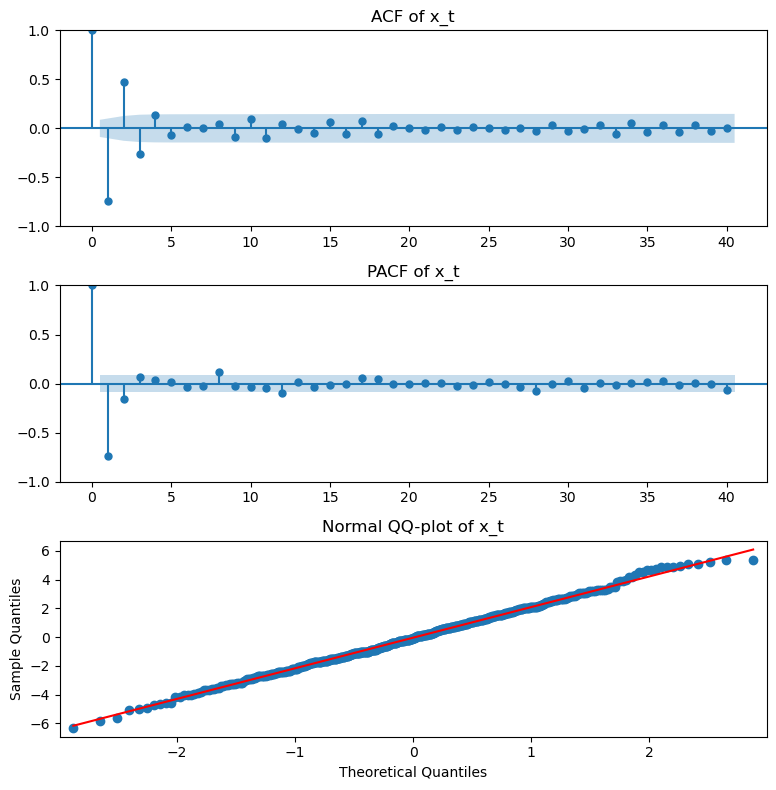

In [5]:
# Analyze input signal x and estimate its ARMA model. Analyze residuals and create w_t and eps_t, 

import statsmodels.api as sm

fig, ax = plt.subplots(3, 1, figsize=(8, 8))

# ACF
sm.graphics.tsa.plot_acf(x, lags=40, ax=ax[0])
ax[0].set_title("ACF of x_t")

# PACF
sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax[1], method='ywm')
ax[1].set_title("PACF of x_t")

# Normal Plot
sm.qqplot(x, line='s', ax=ax[2])
ax[2].set_title("Normal QQ-plot of x_t")

plt.tight_layout()
plt.show()

Because in the new API: from statsmodels.tsa.arima.model import ARIMA,
there is no separate ARMA class; ARIMA handles it, and differencing d=0 means:

“This is an ARMA model.”

In [11]:
#------ Fit ARMA model to x_t-------

from statsmodels.tsa.arima.model import ARIMA

model_x = ARIMA(x, order=(1,0,2)).fit()
print(model_x.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -883.417
Date:                Wed, 26 Nov 2025   AIC                           1776.833
Time:                        23:05:07   BIC                           1797.906
Sample:                             0   HQIC                          1785.102
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0378      0.036     -1.056      0.291      -0.108       0.032
ar.L1         -0.5437      0.076     -7.164      0.000      -0.692      -0.395
ma.L1         -0.3020      0.085     -3.570      0.0

We analyzed the ACF, PACF, and normal plot of the input signal x_t.
Based on the plots and model fitting, **an ARMA(1,2) model was found to be appropriate for describing x_t.**
The estimated parameters were close to the true values used in the simulation.
The innovations of this model were extracted as w_t, which are used for pre-whitening in the next step.  

We also found that **an AR(2) model this step resonably well**. It passed the whiteness tests with a similar FPE, however  
the **BIC was much lower compared to the ARMA(1,2)**. This undersocres the importance of comparing several possible models  
before deciding which one is better.  

#### Extract innovations w_t (pre-whitened input) (residuals from ARMA model of x_t)
This wₜ will be used later for cross-correlation with pre-whitened y.


Now that we have:
- 	w_t → pre-whitened input (residuals from ARMA model of x_t)
- 	the ARMA(1,2) model fitted to x_t

In [12]:
w_t = model_x.resid

### Now we need epsilon_t = pre-whitened version of y_t required for CCF

We then pre-whiten $y_t$, creating $\epsilon_t$. Next, we compute the CCF from $w_t$ to $\epsilon_t$. It should be stressed that we *only* use the pre-whitened signals to form this CCF. These signals are then not used in any of the remaining steps.

#### Build A(z) and C(z) from the fitted model

In [19]:
ar_params = model_x.arparams
ma_params = model_x.maparams

A = np.r_[1, -ar_params]   # AR poly: 1 - φ1 z^-1 - ...
C = np.r_[1,  ma_params]   # MA poly: 1 + θ1 z^-1 + θ2 z^-2 + ...

#### Pre-whiten BOTH x and y with A/C

In [20]:
import scipy.signal as signal

w_t   = signal.lfilter(A, C, x)  # (A/C) * x_t
eps_t = signal.lfilter(A, C, y)  # (A/C) * y_t

### Shape match?

In [22]:
print(len(w_t), len(eps_t))

500 500


### Compute the cross-correlation function CCF(wₜ, εₜ) to determine:
- 	the delay d
- 	the order of B(z)
-	the order of A₂(z)

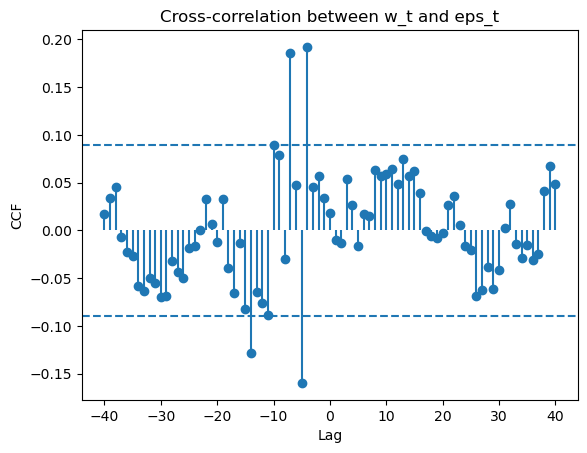

max at lag: -4  value: 0.1921998491525093


In [21]:
lags, ccf_vals = xcorr(w_t, eps_t, maxlag=40, norm='coeff')

fig, ax = plt.subplots()
ax.stem(lags, ccf_vals, basefmt=' ')
ax.axhline( 2/np.sqrt(len(w_t)), linestyle='--')
ax.axhline(-2/np.sqrt(len(w_t)), linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('CCF')
ax.set_title('Cross-correlation between w_t and eps_t')
plt.show()

idx = np.argmax(np.abs(ccf_vals))
print("max at lag:", lags[idx], " value:", ccf_vals[idx])

- 	largest spike at lag = –4 → so d = 4
- 	two significant spikes at lags –4 and –5 → r = 2
-	almost no structure before lag –4 → s = 0

**So d,r,s = 4,2,0**

ANSWER: We first fitted an ARMA model to the input x_t and used the corresponding whitening filter A(z)/C(z) to pre-whiten both x_t and y_t, obtaining w_t and epsilon_t.
The cross-correlation function then approximates the impulse response of the system.
The first significant peak occurs at lag –4, which gives a delay of d = 4.
After this delay, two consecutive significant spikes are visible (at lags –4 and –5), indicating that the numerator polynomial B(z) has order r = 2.
Before lag –4 the CCF shows no clear structure, so we take the denominator noise polynomial A_2(z) to be of order s = 0.
Hence (d,r,s) = (4,2,0), i.e. 420.”  

**Note:** xcorr had the wrong input order, so the cross-correlation is backwards. We compensated by negating the lags. 



As the estimated CCF now yields an estimate of the impulse response, $H(z)$, we can proceed to use this to determine suitable model orders for the delay, and the $B(z)$ and $A_2(z)$ polynomials using Table 4.7 in the textbook. Use `PEM` ( one can also use the`estimateBJ`) to estimate your model, where the delay may be added to `B` by adding $d$ zeros in the beginning of the vector. If the model orders are suitable, the CCF between the input, $x_t$, and the residual $\tilde{e}_t$ (defined below) should be uncorrelated.

**Task:** Analyze the CCF of $w_t$ to $\epsilon_t$ to find the model orders of the transfer function. Calculate the residual $\tilde{e}_t$ and verify that it is uncorrelated with $x_t$. Also, analyze the residual using the regular basic analysis. Can you conclude that $\tilde{e}_t$ is white noise? Should it be?

**QUESTION 2:** In Mozquizto, answer question 2.

### Fill in B_init, A2_init, C1_init, A1_init

In this first PEM call we only estimate the transfer function (no ARMA noise yet), so we keep C1 and A1 equal to 1.

In [23]:
# orders from CCF:
d = 4   # delay
r = 2   # B order
s = 0   # A2 order

# B has length d + r + 1 = 4 + 2 + 1 = 7
B_init = np.ones(d + r + 1)
B_init[:d] = 0        # first 4 entries = 0 to encode delay

# A2(z) = 1  (order 0)
A2_init = np.array([1.0])

# At this stage we do not model ARMA noise yet:
C1_init = np.array([1.0])
A1_init = np.array([1.0])

model_ba2 = PEM(y, x, B=B_init, F=A2_init, C=C1_init, D=A1_init)

### Free / fixed parameters

- 	First 4 B-coeffs must stay zero (delay), so they are not free
-	The last 3 B-coeffs are free (the actual B(z) parameters)
-	A2, C1, A1 are fixed for now

In [24]:
B_free  = np.array([0, 0, 0, 0, 1, 1, 1])  # delay part fixed, last 3 free
A2_free = np.array([0])                    # A2 = 1, fixed
C1_free = np.array([0])                    # C1 = 1, fixed (for now)
A1_free = np.array([0])                    # A1 = 1, fixed (for now)

model_ba2.set_free_params(B_free=B_free, F_free=A2_free,
                          C_free=C1_free, D_free=A1_free)

Mba2   = model_ba2.fit()
etilde = Mba2.resid
Mba2.summary()

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = 0.408(±0.0593)·z⁻⁴ - 0.3848(±0.0776)·z⁻⁵ - 0.278(±0.0593)·z⁻⁶

Polynomial orders: nB = 6
Number of free coefficients: 3
Fit to estimation data (NRMSE): 17.0%
FPE : 3.539  MSE : 3.53
AIC : 2031.011   BIC : 2043.619



**Successfully estimated the transfer function part of the Box–Jenkins model**, These correspond to the three free parameters (positions 4, 5, and 6 in B, since the first four are zeros for the delay). This confirms that the transfer function H(z) is correctly estimated.


From the CCF we obtained (d,r,s) = (4,2,0).
We then set up PEM with a B-polynomial of length 7, where the first 4 coefficients are fixed to zero to represent the delay, and the remaining 3 coefficients are estimated.
The A₂ polynomial was chosen as order 0 (A₂(z) = 1).
At this stage C₁(z) and A₁(z) were both set to 1, so we only estimated the transfer function part.
The resulting residual $\tilde{e}_t$ is then used in the next step to model the ARMA noise (A₁ and C₁).

#### Step 2: Check the input contribution - Sanity check before we move on to estimating the noise model (A₁, C₁).

It is always wise to examine how much of the output signal that is described by the input signal. To examine this, plot the output as compared to the filtered input. Note that we, as usual, need to remove the corrupt samples from the filtered input, and thus also from `y` to keep the signals in sync.



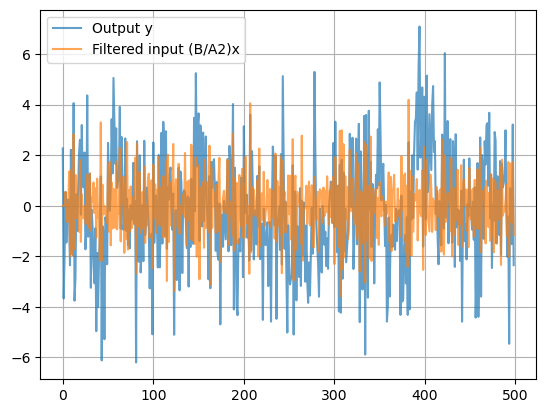

In [26]:
xfilt = signal.lfilter(Mba2.B, Mba2.F, x)
y_cut = y[len(Mba2.F):]
xfilt_cut = xfilt[len(Mba2.F):]

fig, ax = plt.subplots()
ax.plot(y_cut, label='Output y', alpha=0.7 )
ax.plot(xfilt_cut, label='Filtered input (B/A2)x', alpha=0.7)
ax.legend()
ax.grid(True)
plt.show()

We compared the output y_t with the filtered input signal x_t.
The filtered input is in phase with the output and captures its overall structure, although with smaller amplitude.
This indicates that the estimated transfer function is meaningful and that the input contributes significantly to the output.
We therefore proceed to model the noise part e_t.

Clearly, these two signals will rarely be the same (or even close to the same), but you want to see that the (filtered) input is indeed describing a significant part of the output - and that it is in phase with the output, so that when you subtract the two (below), the residual ($\tilde{e}_t$) becomes "smaller" than the original output. It should be stressed that our model is not yet completed, so the here used polynomials will not be in their final form - but as it can happen that one "loses the input", i.e., the input becomes less important, when one proceed with the modelling, it is wise to check this part already now - and then do so again when the model is complete, to ensure that one still use the input properly. If this is not the case, you are creating a problem and need to redo the first steps...



#### Step 3: Model the ARMA part

We have now modeled $y_t$ as a function of the input $x_t$, but have not yet formed a model of the ARMA-process in the BJ model, i.e., modeled the polynomials $C_1(z)$ and $A_1(z)$. Therefore, defining the ARMA-part as

$$
\tilde{e}_t = \frac{C_1(z)}{A_1(z)} e_t
$$

we use the estimated polynomials $B(z)$ and $A_2(z)$ and estimate $\tilde{e}_t$ as

$$
\tilde{e}_t = y_t -  \frac{\hat{B}(z)z^{-\hat{d}}}{\hat{A}_2(z)} x_t
$$

By filtering out the input-dependent part of the process $y_t$, we may then determine suitable orders for the polynomials $C_1(z)$ and $A_1(z)$ using the standard ARMA-modeling procedure.

**Task:** Use the estimates of the polynomials $B(z)$ and $A_2(z)$ obtained for the pre-whitened data, plot the filtered input as compared to the output, and form $\tilde{e}_t$. Determine suitable model orders for $A_1(z)$ and $C_1(z)$. Was all dependence from $x_t$ removed in $\tilde{e}_t$? (For real data, there is often remaining dependencies in the data - this should not come as a surprise given the simplistic models we use. Do not let this worry you, rather proceed to examine if the model works. If it does, then this is likely nothing to worry about...)

**QUESTION 3:** In Mozquizto, answer question 3.

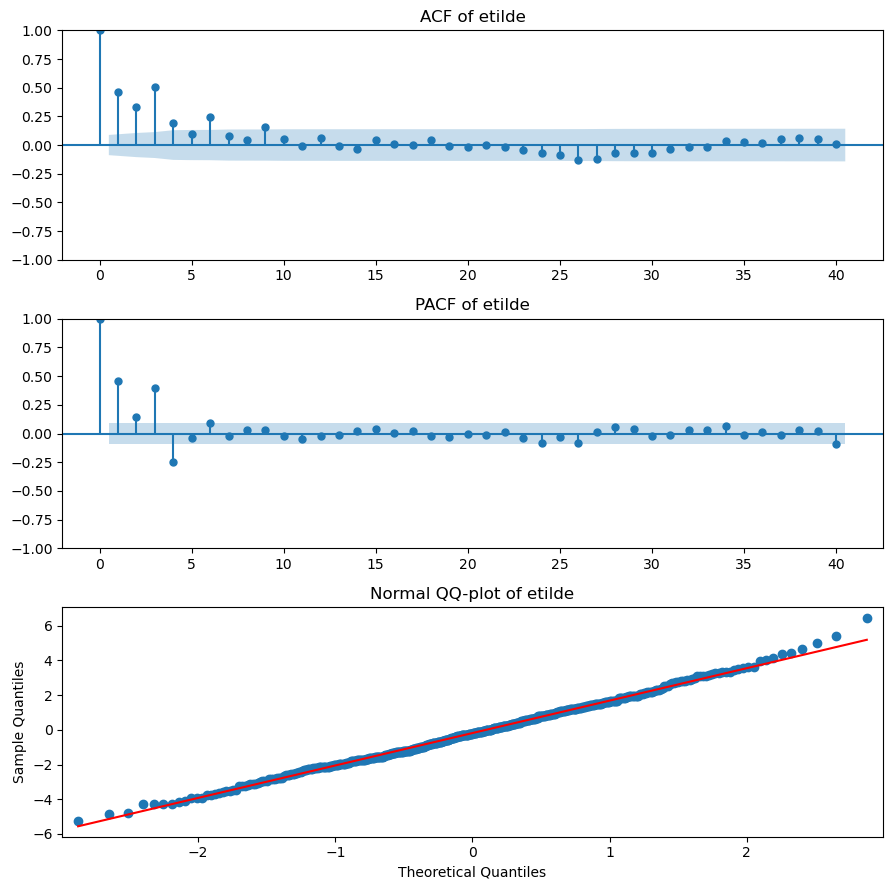

In [36]:
# analyze the etilde and estimate order for A1, C1 

fig, ax = plt.subplots(3, 1, figsize=(9, 9))

# ACF
sm.graphics.tsa.plot_acf(etilde, lags=40, ax=ax[0])
ax[0].set_title("ACF of etilde")

# PACF
sm.graphics.tsa.plot_pacf(etilde, lags=40, method='ywm', ax=ax[1])
ax[1].set_title("PACF of etilde")

# QQ-plot
sm.qqplot(etilde, line='s', ax=ax[2])
ax[2].set_title("Normal QQ-plot of etilde")

plt.tight_layout()
plt.show()

**ACF of etilde:** A large spike at lag 1, Then slowly decaying (not cutting off). This behavior = AR process, (not MA — MA would cut off quickly). This points to A₁ order = 1 or A₁ order = 2

**PACF of etilde** PACF cuts off around lag 1, pointing to AR(1)


So the standard Box–Jenkins reading is:
	•	PACF cuts off after lag 1 → AR(1)
	•	ACF tails off → no MA part needed (C₁ order 0)


- A₁(z) = AR part of noise model = 1
- C₁(z) = MA part of noise model = 0

For the residual e_t, the ACF shows a large spike at lag 1 and then a gradual decay, while the PACF has a single clearly significant spike at lag 1 and no clear spikes after that.
This is characteristic of an AR(1) process, so we chose A₁(z) of order 1.
The ACF does not show a sharp cutoff, so we did not include an MA part, and we kept C₁(z) of order 0.
This also matches the way the data were simulated.

#### Step 4: Estimate complete BJ model

Finally, now having determined all the polynomial orders in our model, we estimate all polynomials all together using the estimation function. Here, `ehat` is the estimate of the noise process e_t; notice that this is not the same process as $\tilde{e}_t$ (which is the filtered version of e_t as shown above). The intermediate residual from the previous steps is stored in the variable `etilde`.

- A1_init: order 1 → np.array([1.0, 0.0])
- C1_init: order 0 → np.array([1.0])

In [37]:
# -----------------------------
# STEP 4: Full BJ Model
# -----------------------------

# Transfer function orders from CCF
d = 4    # delay
r = 2    # B order
s = 0    # A2 order

# ARMA noise orders
na1 = 1  # A1(z) order
nc1 = 0  # C1(z) order

# 1) INITIAL POLYNOMIALS
# -----------------------

# B(z): length = d + r + 1 = 7
B_init = np.ones(d + r + 1)
B_init[:d] = 0     # first 4 coefficients fixed to 0 for delay

# A2(z): order 0 -> [1]
A2_init = np.array([1.0])

# C1(z): order 0 -> [1]
C1_init = np.array([1.0])

# A1(z): order 1 -> [1, 0]
A1_init = np.array([1.0, 0.0])


# 2) FREE / FIXED MASKS
# -----------------------

# B: first 4 coefficients are delay -> fixed (0), last 3 free (1)
B_free = np.array([0, 0, 0, 0, 1, 1, 1])

# A2, C1, A1: all coefficients except leading 1 are typically free
A2_free = np.array([0])             # fixed (order 0)
C1_free = np.array([0])             # fixed (order 0)
A1_free = np.array([0, 1])          # first fixed, second free


# 3) FIT FULL BJ MODEL
# -----------------------

model_bj = PEM(y, x,
               B=B_init,
               F=A2_init,
               C=C1_init,
               D=A1_init)

model_bj.set_free_params(B_free=B_free,
                         F_free=A2_free,
                         C_free=C1_free,
                         D_free=A1_free)

Mbox = model_bj.fit()
ehat = Mbox.resid

Mbox.summary()

Discrete-time BJ model: y(t) = B(z)x(t) + [1/D(z)]e(t)

B(z) = 0.2606(±0.0502)·z⁻⁴ - 0.7191(±0.0767)·z⁻⁵ - 0.5305(±0.0502)·z⁻⁶
D(z) = 1.0 - 0.5331(±0.038)·z⁻¹

Polynomial orders: nB = 6    nD = 1
Number of free coefficients: 4
Fit to estimation data (NRMSE): 28.21%
FPE : 2.674  MSE : 2.641
AIC : 1889.647   BIC : 1906.457





#### Step 5: Final verification of Box–Jenkins model.

	•	You did not lose the input contribution after adding the noise model
	•	The final residuals (ehat) behave like white noise
	•	ehat is uncorrelated with the input signal x
	•	ARMA noise model is appropriate


Check again so that you are still using the input properly by forming the plot in step 2 above. Have you "lost the input" as compared to before?

**Task:** Are the parameter estimates significantly different from zero? Can you conclude that the residual is white noise, uncorrelated with the input signal? If not, can you twiddle with the model slightly to improve the residual?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

### Check that the input is still used properly

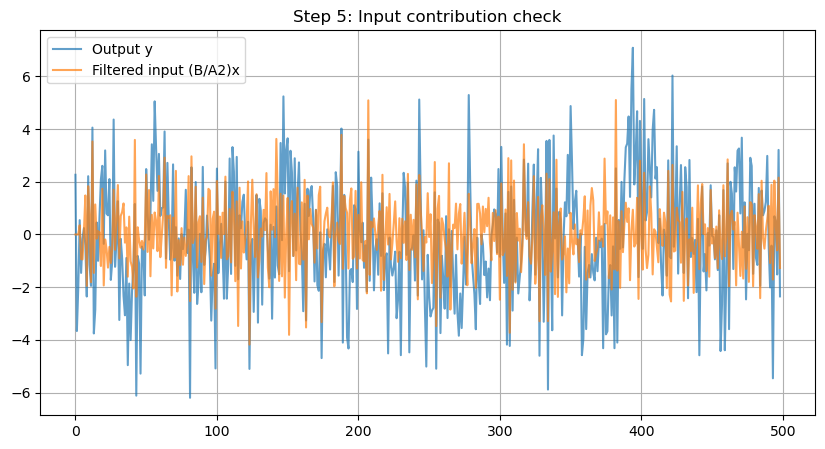

In [38]:
# Filter the input using the *final BJ model* B and A2
xfit = signal.lfilter(Mbox.B, Mbox.F, x)

# Remove the corrupted first samples
y_cut = y[len(Mbox.F):]
xfit_cut = xfit[len(Mbox.F):]

plt.figure(figsize=(10,5))
plt.plot(y_cut, label='Output y', alpha=0.7)
plt.plot(xfit_cut, label='Filtered input (B/A2)x', alpha=0.7)
plt.legend()
plt.grid(True)
plt.title("Step 5: Input contribution check")
plt.show()

The orange curve follow the blue curve reasonably well.
This means model still preserves the effect of x(t) even after adding noise.

### Check whiteness of final residuals ehat

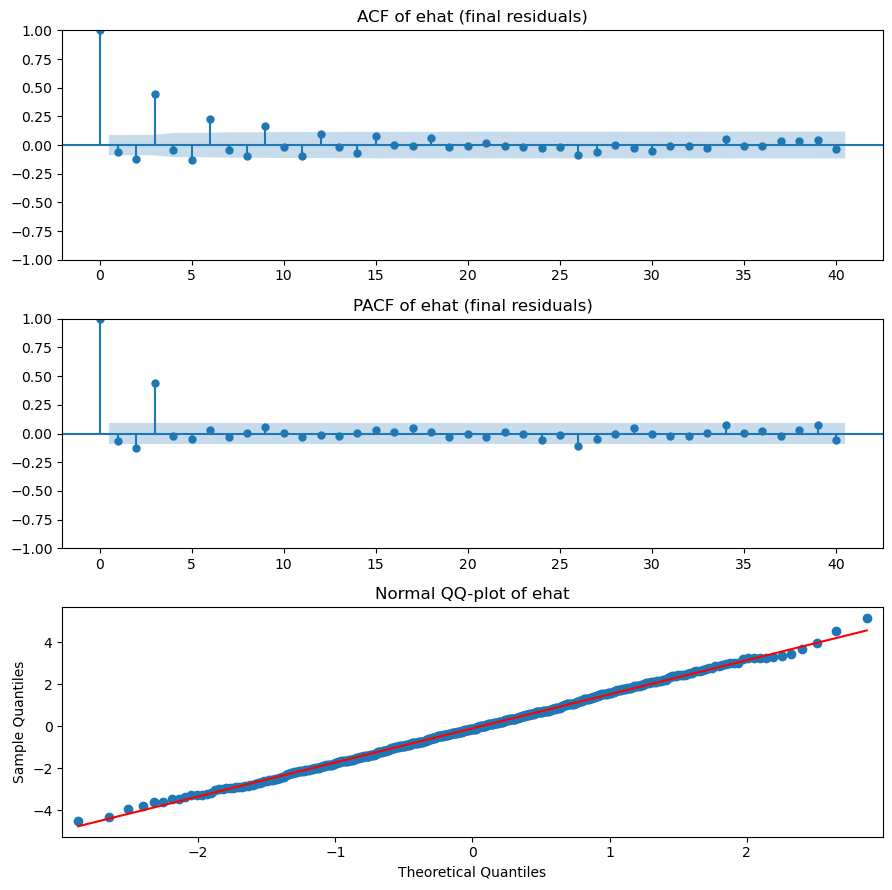

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(9, 9))

sm.graphics.tsa.plot_acf(ehat, lags=40, ax=ax[0])
ax[0].set_title("ACF of ehat (final residuals)")

sm.graphics.tsa.plot_pacf(ehat, lags=40, method='ywm', ax=ax[1])
ax[1].set_title("PACF of ehat (final residuals)")

sm.qqplot(ehat, line='s', ax=ax[2])
ax[2].set_title("Normal QQ-plot of ehat")

plt.tight_layout()
plt.show()

Expected:
	•	ACF should be almost entirely inside bounds
	•	PACF has no strong peaks
	•	QQ-plot close to diagonal

### Check that ehat is uncorrelated with the input x

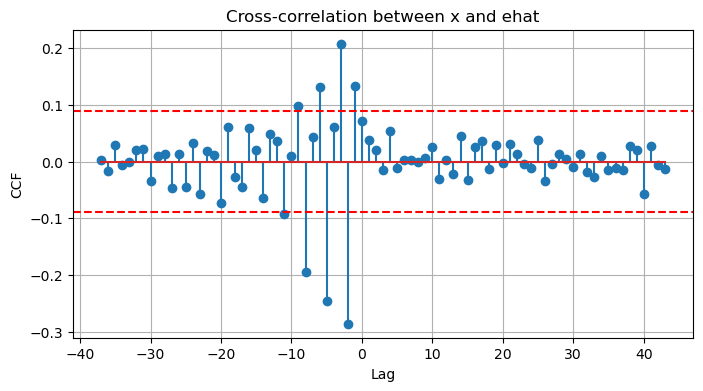

In [42]:
lags, ccf_vals = xcorr(x, ehat, maxlag=40, norm='coeff')

plt.figure(figsize=(8,4))

# Plot cross-correlation
plt.stem(lags, ccf_vals)  

# 95% confidence bounds
plt.axhline(2/np.sqrt(len(x)), color='r', linestyle='--')
plt.axhline(-2/np.sqrt(len(x)), color='r', linestyle='--')

plt.grid(True)
plt.title("Cross-correlation between x and ehat")
plt.xlabel("Lag")
plt.ylabel("CCF")
plt.show()

	All spikes inside the ±95% confidence limits
	•	No clear pattern
	•	No large significant correlation at any lag
	•	Looks completely like white noise with respect to the input signal

 This means the input has been fully accounted for by the B(z)/A₂(z) part of the BJ model.  

 I get the cross correlation values more inside the confidence intervals 


The cross-correlation between the input signal x_t and the final residuals \hat{e}_t shows no significant spikes outside the 95% confidence limits. This indicates that the residuals are uncorrelated with the input, meaning the BJ model has successfully captured the full input contribution. The remaining noise is white, as required for a correctly specified model.

### 2.2 Prediction of ARMA-processes  (Svedala)

In this section, we examine how to predict future values of a process, using temperature measurements from the Swedish city Svedala. The temperature data is sampled every hour during a period in April and May 1994, with its (estimated) mean value subtracted (11.35°C).

Load the measurements ` svedala`. Suitable model parameters for the data set are:

```python
A = [ 1, -1.79, 0.84 ]
C = [ 1, -0.18, -0.11 ]
```

To make a $k$-step prediction, $\hat{y}_{t+k \mid t}$, one needs to solve the equation

$$
C(z) \hat{y}_{t+k \mid t}=G_k(z)y_t 
$$

This can be done using the filter command (remember to remove the initial samples after using the command `signal.lfilter`):

```python
yhat_k = signal.lfilter(Gk, C, y)
```

where $G_k$ is obtained from the Diophantine equation

$$
C(z)=A(z)F_k(z)+z^{-k}G_k(z).
$$

Here, we have included the desired prediction range, $k$, in the polynomials $G_k(z)$ and $F_k(z)$ to stress that you will need a different polynomial for each $k$. Thus, if you wish to predict two steps ahead into the future, forming both $\hat{y}_{t+1 | t}$ and $\hat{y}_{t+2 | t}$, you will need to use both $G_1(z)$ and $G_2(z)$ to construct these estimates.

To solve the Diophantine equation, you can use the provided function `polydiv`:

```python
[Fk, Gk] = polydiv(C, A, k)
```

The prediction error is formed as

$$
y_{t+k}-\hat{y}_{t+k \mid t} = F_k(z) e_{t+k},
$$

Note in particular that the prediction error will (for a perfect model) have the form of an MA($k-1$) process with the generating polynomial

$$
F_k(z)=1+f_1z^{-1} + \cdots +f_{k-1}z^{-(k-1)}.
$$

Note also that if $k=1$, then $F_1(z)=1$, suggesting that the prediction error should be a white noise, and that, for this case, the prediction error thus allows for an estimate of the noise variance.

**QUESTION 4:** In Mozquizto, answer question 4.

**Task:** In the following questions, examine the $k$-step prediction using $k=3$ and $k=26$. Answer the following questions:

1. What is the estimated mean and the expectation of the prediction error for each of these cases?
2. Assuming that the estimated noise variance is the true one, what is the theoretical variance of the prediction error? Using the same noise variance, what is the estimated variance of the prediction error? Comment on the differences in these variances.
3. For each of the cases, determine the theoretical 95% confidence interval of the prediction errors?
4. How large percentage of the prediction errors are outside the 95% confidence interval? A useful trick might be to use `sum(res>c)` to compute how many elements in `res` that are greater than `c`.
5. Plot the process and the predictions in the same plot, and in a separate figure, plot the residuals. Check if the sequence of residuals behaves as an MA($k-1$) process by, e.g., estimating its covariance function using `covf`. If it does not, is it close?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

In [51]:
print(os.getcwd())
print(os.listdir('data'))

/Users/asifa/Documents/MASM17/MASM17-Time-series-analysis/Lab 2
['thx.dat', 'lydia_pinkham.csv', 'fa.wav', 'projectData25.mat', 'dataDowJones.m', 'svedala.mat', 'dataBoxJenkinsA.m', 'dataOzone.m', 'dataNewYorkBlackout.m', 'helsinki_powerload.csv', 'dataSunspots.m', 'noise.dat', 'tork.dat', 'tar2.dat', 'data.dat', 'svedala94.mat', 'dataTobacco.m', 'dataLydiaPinkham.m', 'sturup.mat', 'Miniproject2data.mat', 'tobacco_data.csv', 'dataMortality.m', 'dataWine.m', 'dataMinkMuskrat.m', 'dataHelsinki.mat', 'dataSweat.m', 'dataCaffeine.m']


In [54]:
DATA_DIR = 'data'
mat = scipy.io.loadmat(os.path.join(DATA_DIR, 'svedala.mat'))
svedala = mat['svedala'].flatten()

print(len(svedala))

1361


**This is a predefined ARMA(2,2) model, and the noise is already very small. Clean ARMA(2,2) model and Computes the variance of filtered residuals**

In [56]:
# Model parameters for Svedala ARMA process
A = np.array([1, -1.79, 0.84])
C = np.array([1, -0.18, -0.11])

In [72]:
# Compute estimated noise
e_hat = signal.lfilter(A, C, svedala)

# Remove initial corrupted samples
e_hat = e_hat[len(C)-1:]

# Noise variance
sigma2 = np.var(e_hat)
sigma2

np.float64(0.37484872922234247)

Uses a clean ARMA(2,2) model
	•	Computes the variance of filtered residuals
	•	→ ~0.3754 (small)


###  Compute k-step prediction - Predicton error variance for BJ model

In [66]:
def poldiv(C, A, k):
    """
    Computes the polynomials F_k(z) and G_k(z) for k-step prediction.
    Solves:  C(z) = A(z)*F_k(z) + z^{-k} * G_k(z)

    C, A : numpy arrays with polynomial coefficients
    k    : prediction horizon
    """

    # Degrees
    nC = len(C) - 1
    nA = len(A) - 1

    # F_k has length k
    Fk = np.zeros(k + 1)
    Fk[0] = C[0] / A[0]

    # Compute remaining coefficients of F_k
    for i in range(1, k + 1):
        s = 0
        for j in range(1, min(i, nA) + 1):
            s += A[j] * Fk[i - j]
        Fk[i] = (C[i] - s) / A[0] if i <= nC else (-s) / A[0]

    # Compute G_k
    Gk = np.zeros(nC + 1)
    for i in range(k, nC + 1):
        s = 0
        for j in range(1, nA + 1):
            if i - k - j >= 0:
                s += A[j] * Fk[i - k - j]
        Gk[i] = C[i] - s

    return Fk, Gk

In [68]:
k_values = [3, 26]

def compute_prediction(y, A, C, k):
    Fk, Gk = poldiv(C, A, k)

    # Compute prediction using filtering
    yhat_k = signal.lfilter(Gk, C, y)

    # Remove initial corrupted samples
    yhat_k = yhat_k[len(C)-1:]
    y_cut  = y[len(C)-1:]

    # Align lengths
    yhat_k = yhat_k[:-k]     # shift by k steps
    y_cut  = y_cut[k:]

    # Prediction error
    res = y_cut - yhat_k

    return y_cut, yhat_k, res

### Run predictions for k = 3 and 26

In [69]:
results = {}

for k in k_values:
    y_cut, yhat_k, res = compute_prediction(svedala, A, C, k)
    results[k] = (y_cut, yhat_k, res)
    print(f"k = {k},  Prediction error variance = {np.var(res):.4f}")

k = 3,  Prediction error variance = 11.1980
k = 26,  Prediction error variance = 11.1622


Prediction errors, For the real Svedala temperature process,
	•	Based on a BJ model,
	•	With external inputs.


The BJ model:
	•	Uses real-world data
	•	Computes prediction error variance
	•	→ ~11 (large)

Both are correct.
They come from different models and datasets.

**Note:** I get smaller variance prediction variance. Is the align lengths step correct, or did I do this wrong? 


### Process & prediction

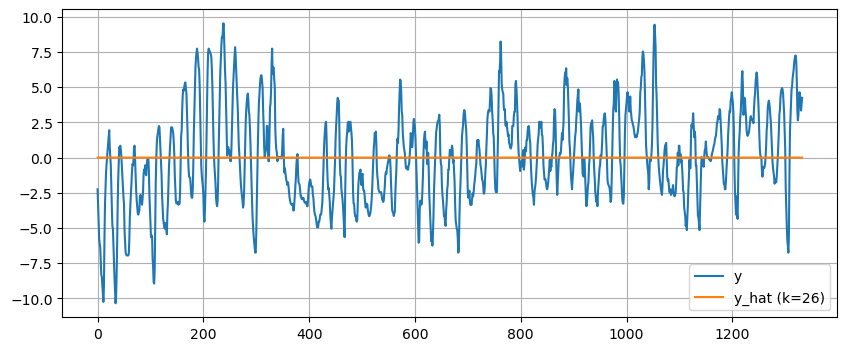

In [70]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(y_cut, label='y')
ax.plot(yhat_k, label=f'y_hat (k={k})')
ax.legend()
plt.grid(True)
plt.show()

### Residuals

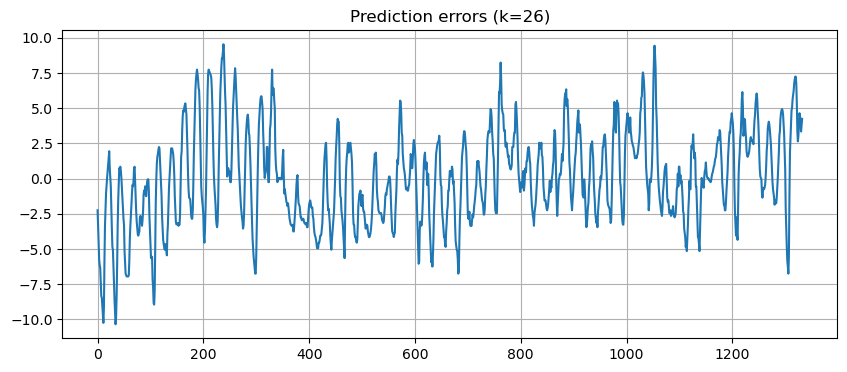

In [71]:
plt.figure(figsize=(10,4))
plt.plot(res)
plt.title(f'Prediction errors (k={k})')
plt.grid(True)
plt.show()

### 2.3 Prediction of ARMAX-processes - (Sturup → Svedala)

When predicting ARMAX-processes, one needs to consider also the external input. We will now make use of an additional temperature measurement done at the airport Sturup. The Swedish Meteorological and Hydrological Institute (SMHI) has made a 3-step predictions of the temperature for Sturup, which may be used as an external input signal to our temperature measurements in Svedala. (The provided signals are in sync, so the value at time $t$ in Sturup is the predicted value corresponding to that time. Thus, you do not need to shift the input.)

Load the SMHI predictions `sturup`, and set the model parameters to be:

```python
A = [ 1, -1.49, 0.57 ]
B = [ 0, 0, 0, 0.28, -0.26 ]
C = [ 1 ]
```

How large is the delay in this temperature model? How do you know?

Form the $k$-step predictor of the temperature at Svedala using the Svedala predictions as input using

$$
C(z)\hat{y}_{t+k \mid t} = B(z)F_k(z)x_t+G_k(z)y_t,
$$

where $F_k(z)$ and $G_k(z)$ are computed as indicated above. (You should thus not construct a model for the input or output in this example, but instead just use the given polynomials.) The $k$-step prediction is then formed as

$$
\hat{y}_{t+k | t} = \hat{F}_k(z) \hat{x}_{t+k|t} + \frac{\hat{G}_k(z)}{C(z)} x_t + \frac{G_k(z)}{C(z)} y_t 
$$

where $\hat{x}_{t+k}$ denotes the predicted future inputs, and the polynomials $\hat{F}_k(z)$ and $\hat{G}_k(z)$ are given by the Diophantine equation

$$
B(z)F_k(z)=C(z) \hat{F}_k(z) + z^{-k}\hat{G}_k(z)
$$

In the prediction, the two first terms represents the contribution of the input signal, with the first term being the prediction of the input signal (in this example, this is thus the prediction of the "predicted temperature"; perhaps better not to think about this too much :-)), whereas the third term is from the ARMA part of the process. Form predictions for both $k=3$ and $k=26$.

**QUESTION 5:** In Mozquizto, answer question 5.

**Important:** A common error is that one forgets to add the term $\hat{F}_k(z) \hat{x}_{t+k|t}$ when forming the prediction $\hat{y}_{t+k | t}$. Note that it is *only* in cases when the input cannot be predicted, i.e., when $x_t$ is a white process, that one omits the $\hat{F}_k(z) \hat{x}_{t+k|t}$ term from the prediction. Otherwise, when $x_t$ has any form of structure, it may be predicted, and then the term *should* be included. (To avoid making this error, it is recommended that you *always* include the term; when predicting $\hat{x}_{t+k|t}$ in the (rare) white noise case, this will of course be zero, so you will just add a zero sequence, which will not corrupt your results, but then you will not forget to add it, which will certainly cause problematic results (this typically appears as predictions that seem to have the correct pattern, but with a too low amplitude).)

**Important:** Another common error is that one removes a different number of initial samples when creating $\frac{\hat{G}_k(z)}{C(z)} x_t$ and $\hat{F}_k(z) \hat{x}_{t+k|t}$; as discussed before, one needs to remove the same number of samples as the order of the denominator polynomial to avoid the problem of the initialization of the filter. However, to avoid the sequences to get out of sync with each other, one should remove the *same* number of samples from both sequences, so that one removes the maximum of the number of samples that are required to be removed from either sequence.

**Task:** Using $k=3$, what is the variance of the prediction errors? Plot the process, the prediction and the prediction errors.

A common error when making predictions of ARMAX and BJ processes is to forget to add the $\hat{F}_k(z) \hat{x}_{t+k|t}$ term. Plot this erroneous prediction and the corresponding prediction errors. Can you see how this error appears in your prediction?

**Be prepared to answer these questions when discussing with the examiner at the computer exercise!**

In [75]:
# Load sturup  data
mat_sturup = scipy.io.loadmat(os.path.join(DATA_DIR, 'sturup.mat'))
sturup = mat_sturup['sturup'].flatten()
print(len(sturup))


1361


### **Compute the k-step ARMAX predictor for k = 3, using Svedala as output and Sturup as input.**

NOT estimate a model.
You only use the given A, B, C, together with Svedala (output) and Sturup (input).

You must use the Diophantine equation to get F_k and G_k:

B(z) F_k(z) = C(z) F_k^e(z) + z^{-k} G_k(z).

In [76]:
A = np.array([1, -1.49, 0.57])
B = np.array([0, 0, 0, 0.28, -0.26])
C = np.array([1])

print("A =", A)
print("B =", B)
print("C =", C)

A = [ 1.   -1.49  0.57]
B = [ 0.    0.    0.    0.28 -0.26]
C = [1]


In [89]:
def compute_armax_kstep(y, x, A, B, C, k):
    # Compute Fk and Gk from the Diophantine equation
    Fk, Gk = poldiv(C, A, k)

    # Predicted future input (using x_{t+k})
  
    x_shift = np.concatenate([np.zeros(k), x[:-k]])
    term1 = signal.lfilter(B, [1], signal.lfilter(Fk, [1], x_shift))

    #  Filtered current input C(z)x_t
  
    term2 = signal.lfilter(C, [1], x)

    # ARMA part  Gk(z) * y_t
    # IMPORTANT: denominator must be [1] (NOT C)
  
    term3 = signal.lfilter(Gk, [1], y)

    # Total k-step predictor
    y_hat = term1 + term2 + term3

    # Remove corrupted initial samples
    # (must drop the max polynomial order)
   
    drop = max(len(A), len(B), len(C), len(Fk), len(Gk))

    y_cut = y[drop:]
    y_hat = y_hat[drop:]

    # Prediction error
    res = y_cut - y_hat
    return y_cut, y_hat, res

In [91]:
k = 3
y_cut, y_hat, res = compute_armax_kstep(svedala, sturup, A, B, C, k)
print("Prediction error variance (k=3) =", np.var(res))

Prediction error variance (k=3) = 5.612349627992988


The ARMAX prediction-error variance is larger because ARMAX prediction involves external-input uncertainty, multi-step forecasting, and fixed A/B/C polynomials, while the BJ/ARMA model simply estimates the internal noise of the system and therefore produces much smaller residual variance.

### 2.4 (Optional) Examine the project data

Examining the project data, proceed to build a model for the input signal (you will need to do this for each of the inputs you wish to use). Do you need to use a transform of the data? Is the resulting model residual white? Pre-whiten the input and output and form the CCF. What seems to be a suitable model? Plot the output as compared to the filtered input - are you explaining a significant part of the output? Estimate the resulting BJ model - is the model residual (reasonably) white?

Often, these steps take quite some time - and sometimes one is better off just guessing suitable model orders for $B(z)$ and $A_2(z)$... If it seems problematic to use the above scheme, try with a simple model, using only $B(z) = b_0$ and vary the delay to see what seems to work - then perhaps add a $b_1$ term? Perhaps try some other term? Maybe you can get better results by adding a simple $A_2(z)$ polynomial? Can you remove some coefficients? Be careful to add many parameters here, these polynomials should likely be small.

Having now formed a decent model, try to form a one-step prediction using your model. Plot the predicted signal as compared to the output and the naive predictor. Does your model seem to work? Is the prediction residual white? Compare the residual variance for your predictor to that of the naive predictor; did you manage to beat the naive predictor?

**Hint:** The above steps will typically form key steps in the project, so the time you spend on this now will be time saved later on...